**Задание**

**Цель**: применить на практике базовые ансамблевые методы

**Описание задания**:
В домашнем задании нужно решить задачу классификации наличия болезни сердца у пациентов. Данные для обучения моделей необходимо загрузить самостоятельно с [сайта](#https://www.kaggle.com/fedesoriano/heart-failure-prediction). Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/homeworks/heart.csv')

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Пропусков в данных нет

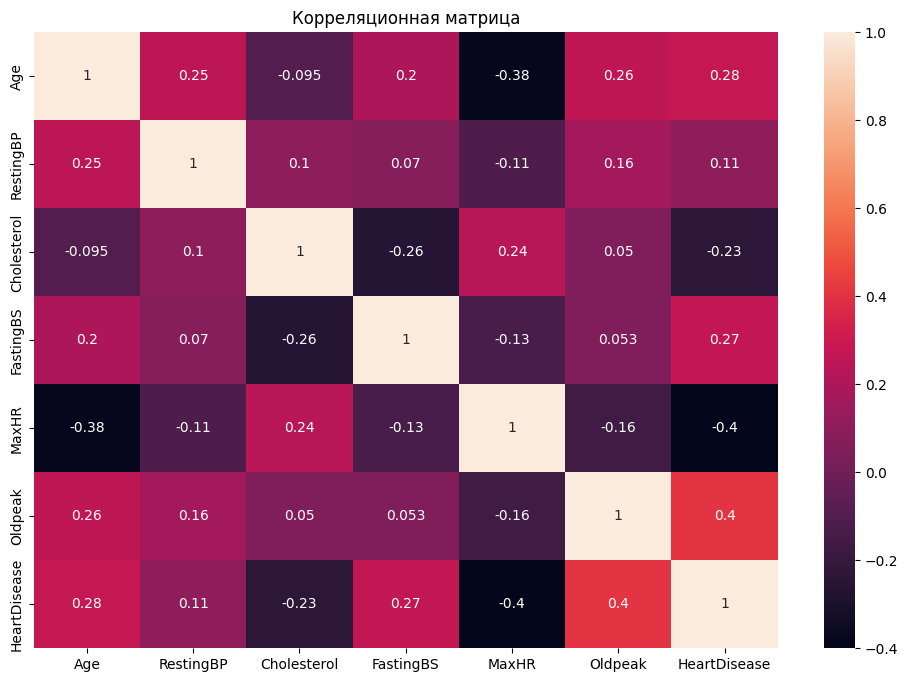

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True)
plt.title('Корреляционная матрица')
plt.show()

Небольшая отрицательная корреляция между целевым признаком и MaxHR и положительная с Oldpeak

In [ ]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [ ]:
def histagram(data, column_names):
  data_hist = data.copy()

  for column_name in column_names:
    column = data_hist[column_name]

    plt.figure(figsize=(8, 5))
    data[column_name].hist(bins=20, edgecolor='k')
    plt.title(f"Гистограмма для '{column_name}'")
    plt.xlabel(column_name)
    plt.show()


In [ ]:
columns_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']
histagram(data, columns_names)

В данных наблюдается перекос в поле и наблюдается выброс значения 0 в Cholesterol и Oldpeak. Целевой признак распределен почти поровну, что хорошо для нашей модели

In [ ]:
import plotly.express as px
def histogram(data, column_names):
  data_hist = data.copy()

  for column_name in column_names:
    column = data_hist[column_name]
    fig = px.histogram(data, x=column_name, color='HeartDisease', title=f"Распределение '{column_name}' по целевому признаку", marginal='box')
    fig.show()

In [ ]:
columns_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
                 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
histogram(data, columns_names)

Графики показывают следующие закономерности:
- большинство болеющих находятся в диапазоне от 51 до 62 лет
- мужчины чаще страдают от сердечных заболеваний
- большинство болеющих жалуются на боль в груди "ASY"
- кровяное давление болеющих чаще всего высокое
- уровень холестерола выше
- пульс высокий
- страдают от стенокардии

*Переведем категориальные переменные*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='HeartDisease'),
                                                    data['HeartDisease'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape

((734, 11), (184, 11))

In [ ]:
categorials = X_train.select_dtypes('object').columns
categorials

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [ ]:
integer = X_train.select_dtypes(['int', 'float']).columns.tolist()

In [ ]:
dummy_train = pd.get_dummies(X_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(X_test[categorials], columns=categorials)

X_train = pd.concat([X_train[integer], dummy_train], axis=1)

X_test = pd.concat([X_test[integer], dummy_test], axis=1)

*Дерево решений*

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
tree_pred = tree.predict(X_test)

In [ ]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78        77
           1       0.86      0.78      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184



*Случайный лес*

In [ ]:
forest = RandomForestClassifier(random_state=42)

In [ ]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
forest_pred = forest.predict(X_test)

In [ ]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



*Значимость признаков*

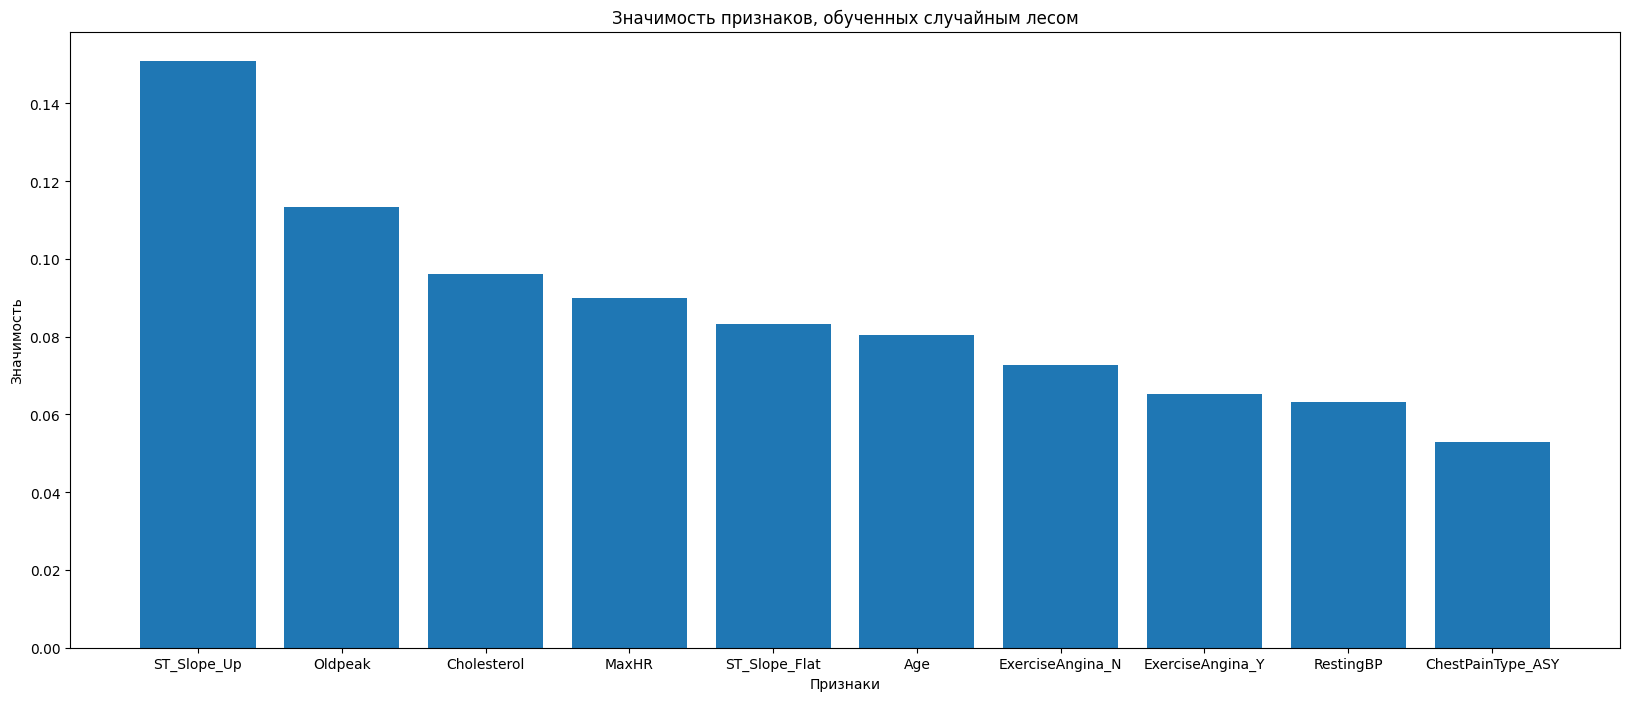

In [ ]:
feature_importances = forest.feature_importances_
idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(20,8))
plt.bar(forest.feature_names_in_[idx][:10], feature_importances[idx][:10])
plt.xlabel("Признаки")
plt.ylabel("Значимость")
plt.title("Значимость признаков, обученных случайным лесом")
plt.show()

*Бэггинг*

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=100,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=42)

In [ ]:
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.5,
                  max_samples=0.5, n_estimators=100, random_state=42)

In [ ]:
bagging_pred = bagging.predict(X_test)

In [ ]:
print(classification_report(y_test, bagging_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



*Стекинг*

In [ ]:
stacking = StackingClassifier(
    [
        ('Random Forest', forest),
        ('SVM', LinearSVC()),
        ('DecisionTree', tree)
    ], RandomForestClassifier(random_state=42))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(random_state=42)),
                               ('SVM', LinearSVC()),
                               ('DecisionTree',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
stacking_pred = stacking.predict(X_test)

In [ ]:
print(classification_report(y_test, stacking_pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82        77
           1       0.86      0.90      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



**Выводы**

Лучше всего себя показала модель случайного леса, метрика accuracy - 0.88

|Модель | Accuracy   
|-----|:-----|
|Decision Tree |0.80 |
|Random Forest |0.88 |
|Bagging |0.86 |
|Stacking |0.86 |

В случайном лесу используется бэггинг и случайные подпространства + он не склонен к переобучению. На мой взгляд, это лучшая модель